In [40]:
sys.path.insert(0, '../../Libraries')
from ltar import LTAR
import numpy as np
import pandas as pd
import numpy.random as random
import scipy.fft as sfft
import pywt
import JacksonsTSPackage as jts
from statsmodels.tsa.api import VAR

In [41]:
def mul_ten_and_mat(tensor, matrix):
    
    matrix_shape = matrix.shape
    ten_length = len(tensor)
    ten_sqr = ten_length*ten_length
    block_matrix = np.zeros((ten_sqr, ten_sqr))

    # Makes the block vector
    trans_vector = sfft.dct(matrix, axis=1)
    block_vector = trans_vector.transpose().reshape(ten_sqr)

    # Makes the block matrix
    transform_tensor = sfft.dct(tensor, axis=0)
    for i in range(ten_length):
        c = i * 3
        block_matrix[c:c+3,c:c+3] = transform_tensor[i]

    result_block_vector = np.matmul(block_matrix, block_vector)
    result_trans_matrix = result_block_vector.reshape(matrix_shape).transpose()
    result_matrix = sfft.idct(result_trans_matrix, axis=1)

    return result_matrix

N = 2000

A = np.array([
    [
        [0.4, 0, 0],
        [0, 0.4, 0],
        [0, 0, 0.4]
    ],
    [
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]
    ],
    [
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]
    ]
    ])

c = np.array(
    [[0.8, 0, 0],
    [0, 0, 0.8],
    [0, 0.8, 0]])

#A = np.random.uniform(-0.3, 0.3, size=(3, 3, 3))

tmp = np.array(
    [
        [0.1, 0.2, 0.3],
        [0.4, 0.5, 0.6],
        [0.7, 0.8, 0.9]
    ])

data_tensor = np.zeros((N, 3, 3))
data_tensor[0] = tmp
for i in range(1, N):
    data_tensor[i] = c + mul_ten_and_mat(A, data_tensor[i-1]) + random.uniform(-1, 1, (3, 3))
data_tensor.shape

(2000, 3, 3)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

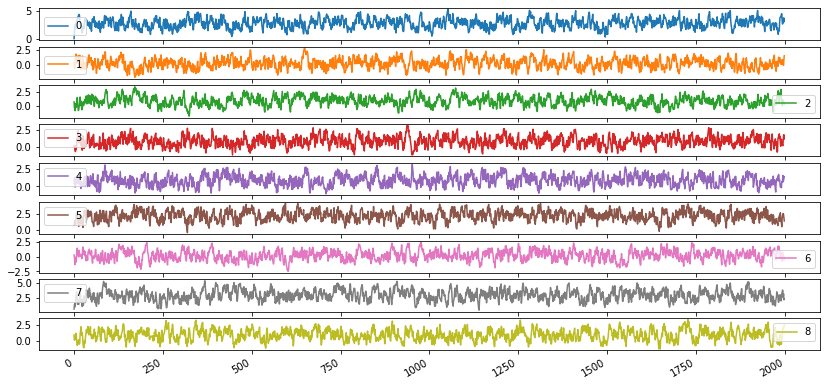

In [42]:
vectorized = pd.DataFrame(jts.tensor_to_vector(data_tensor))
vectorized.plot(figsize = (14, 7), subplots = True)

In [43]:
N_train = 1800
N_test = N - N_train
print(f"N: {N}")
print(f"N_train: {N_train}")
print(f"N_test: {N_test}")

N: 2000
N_train: 1800
N_test: 200


In [44]:
train_tensor = jts.extract_train_tensor(data_tensor, N_train)
test_tensor = jts.extract_test_tensor(data_tensor, N_train, N_test)

In [45]:
p = 1
ltar = LTAR(train_tensor)
ltar.fit(p)

In [46]:
forcast_tensor = ltar.forecast(N_test)
forcast_tensor

array([[[ 3.01785049,  1.30434409,  1.24731644],
        [-0.15721837,  1.72239733,  2.87151721],
        [ 1.08312029,  2.32906829,  0.47108721]],

       [[ 3.10156806,  1.13220694,  1.01571913],
        [ 0.0146409 ,  1.52656353,  2.89840104],
        [ 1.18424765,  2.17661224,  0.33418596]],

       [[ 3.13838166,  1.01642968,  0.83825823],
        [ 0.10487349,  1.44388738,  2.89172415],
        [ 1.22925178,  2.07943764,  0.22191542]],

       ...,

       [[ 3.06144239,  0.67489154,  0.30708941],
        [ 0.20994091,  1.36112708,  2.80391079],
        [ 1.06221922,  1.70636486, -0.24661791]],

       [[ 3.06144239,  0.67489154,  0.30708941],
        [ 0.20994091,  1.36112708,  2.80391079],
        [ 1.06221922,  1.70636486, -0.24661791]],

       [[ 3.06144239,  0.67489154,  0.30708941],
        [ 0.20994091,  1.36112708,  2.80391079],
        [ 1.06221922,  1.70636486, -0.24661791]]])

In [47]:
ltar.c

array([[ 0.89976309, -0.15068156,  0.12426976],
       [-0.10149802,  0.16338722,  0.69688272],
       [ 0.09780441,  0.63793591, -0.39633702]])

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

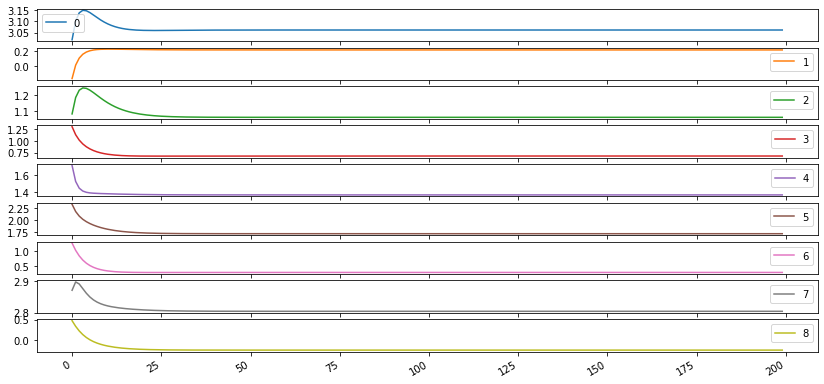

In [48]:
result_vectorized = pd.DataFrame(jts.tensor_to_vector(forcast_tensor))
result_vectorized.plot(figsize = (14, 7), subplots = True)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

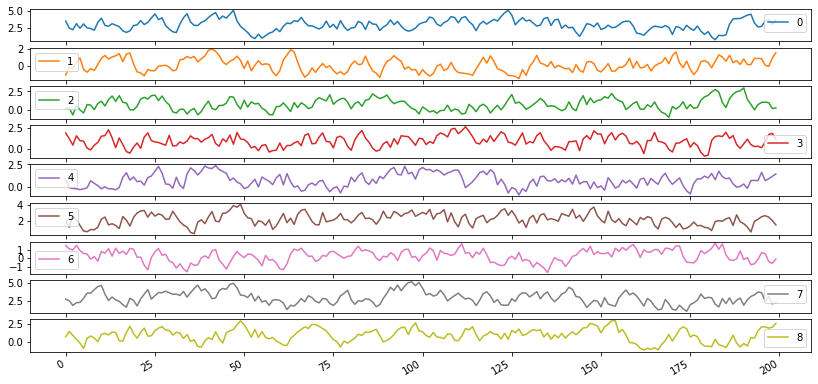

In [49]:
test_vectorized = pd.DataFrame(jts.tensor_to_vector(test_tensor))
test_vectorized.plot(figsize = (14, 7), subplots = True)

In [50]:
error = jts.calc_mape_per_matrix(test_tensor, forcast_tensor)
error = error.rename(columns={"MAPE": "DCT"})
error

,DCT
0,0.317217
1,0.569458
2,0.705
3,0.428723
4,0.611443
...,...
195,0.459177
196,0.468751
197,0.446332
198,0.573763


<AxesSubplot:>

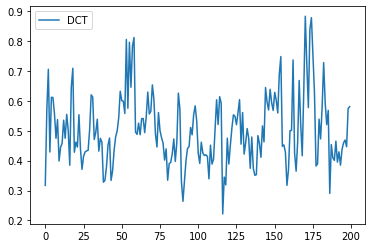

In [51]:
error.plot()

In [52]:
jts.forecast_accuracy(result_vectorized, test_vectorized)

Results
----------------------------------------------------------------------
           ME            MSE            MAE            MAPE
0       0.053          0.695          0.663          27.395%       
1       0.110          0.585          0.634          131.527%      
2       0.319          0.698          0.688          20308.203%    
3       -0.244         0.504          0.568          132.205%      
4       0.644          0.964          0.826          833.224%      
5       -0.470         0.776          0.726          36.096%       
6       0.032          0.526          0.589          146.882%      
7       -0.158         0.728          0.680          24.849%       
8       -1.184         2.193          1.269          131.467%      
